In [3]:
! pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 36.3 MB/s eta 0:00:00


In [4]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [6]:
dev = qml.device('default.qubit', wires=4)

def strongly_entangling_layers(n_layers, weights, wires):
    for l in range(n_layers):
        for i in range(len(wires)):
            qml.RZ(weights[l, i, 0], wires=wires[i])
            qml.RY(weights[l, i, 1], wires=wires[i])
            qml.RZ(weights[l, i, 2], wires=wires[i])
        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i+1) % len(wires)]])

In [7]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    strongly_entangling_layers(num_layers, weights, wires=range(4))
    return qml.expval(qml.PauliZ(wires=0))

def cost_fn(weights, X, y):
    y_pred = np.array([qnode(x, weights) for x in X])
    return np.mean((y_pred - y)**2)

In [8]:
num_layers = 4
num_epochs = 16
weights = np.random.random((num_layers, 4, 3))
opt = qml.GradientDescentOptimizer(0.1)

losses_train = []
losses_val = []

for i in range(num_epochs):
    weights = opt.step(lambda v: cost_fn(v, X_train, y_train), weights)
    loss_train = cost_fn(weights, X_train, y_train)
    loss_val = cost_fn(weights, X_val, y_val)
    losses_train.append(loss_train)
    losses_val.append(loss_val)
    print(f"Epoch {i+1}/{num_epochs}... Loss Train: {loss_train}... Loss Val: {loss_val}")

Epoch 1/16... Loss Train: 0.6807327331784149... Loss Val: 0.6799904533216049
Epoch 2/16... Loss Train: 0.6726215812354182... Loss Val: 0.6734529393914817
Epoch 3/16... Loss Train: 0.664480751141962... Loss Val: 0.6668984507039053
Epoch 4/16... Loss Train: 0.6563312086338652... Loss Val: 0.6603435411011158
Epoch 5/16... Loss Train: 0.6481948927657324... Loss Val: 0.6538053383070378
Epoch 6/16... Loss Train: 0.6400942978037817... Loss Val: 0.6473012314225721
Epoch 7/16... Loss Train: 0.6320520315762881... Loss Val: 0.6408485487434487
Epoch 8/16... Loss Train: 0.6240903692986355... Loss Val: 0.6344642385260003
Epoch 9/16... Loss Train: 0.6162308223024138... Loss Val: 0.6281645652539527
Epoch 10/16... Loss Train: 0.6084937400049596... Loss Val: 0.6219648329916831
Epoch 11/16... Loss Train: 0.6008979609777804... Loss Val: 0.6158791456396365
Epoch 12/16... Loss Train: 0.5934605253925704... Loss Val: 0.6099202115171007
Epoch 13/16... Loss Train: 0.5861964568418359... Loss Val: 0.6040991969289

In [9]:
# Make predictions
y_pred_train = np.array([qnode(x, weights) for x in X_train]).reshape(-1)
y_pred_test = np.array([qnode(x, weights) for x in X_test]).reshape(-1)
y_pred_val = np.array([qnode(x, weights) for x in X_val]).reshape(-1)

In [10]:
# Binarize the predictions
y_pred_train = np.where(y_pred_train < 0.5, 0, 1)
y_pred_test = np.where(y_pred_test < 0.5, 0, 1)
y_pred_val = np.where(y_pred_val < 0.5, 0, 1)

In [11]:
# Calculate accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy Train: {acc_train}, Accuracy Test: {acc_test}, Accuracy Val: {acc_val}")

Accuracy Train: 0.3841642228739003, Accuracy Test: 0.40350877192982454, Accuracy Val: 0.37719298245614036


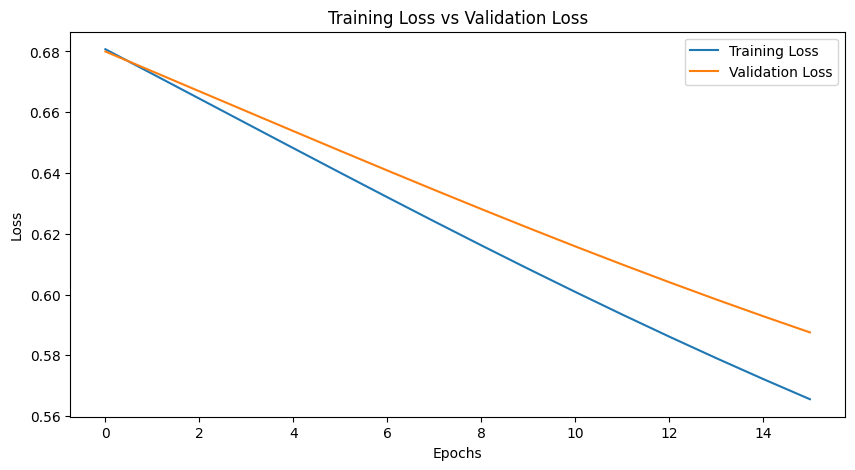

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label="Training Loss")
plt.plot(losses_val, label="Validation Loss")
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()